# Transport through straits

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41559,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:45825,Total threads: 4
Dashboard: /proxy/39547/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:36095,


In [3]:
# CM2 database
#session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/cj877.db') 
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [20]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

### Get transport

DP

Total ITS (+ each)

Add obs values in dashed black

Colours: blue for CM2, red for OM2; dark for 025, light for 1

In [7]:
straits = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':     [-244.6, -243.9, -8.6, -8.6],
              'Ombai' :     [-235.0, -235.0, -9.2, -8.1],
              'Timor' :     [-235.9, -235.9, -11.9, -9.9],
              'Bering' :    [-172, -167, 65.8, 65.8],
              'Denmark' :   [-42, -22, 65.8, 65.8],
            }

In [8]:
rho = 1036 # kg/m^3, mean density of seawater

def calc_transport(expt, session, strait, start_time='0001-01-01', end_time='0499-12-31'):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax>=65:
        raise ValueError('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}: {} transport'.format(expt, strait))
    
    if xmin == xmax:       
        tx_trans = cc.querying.getvar(expt, 'tx_trans_int_z', session, start_time=start_time, end_time=end_time)
        tx_trans = tx_trans.sel(time=slice(start_time, end_time))
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
        # tx_trans = cc.querying.getvar(expt,'tx_trans',session)
        # transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
        #                     .sel(yt_ocean=slice(ymin, ymax))\
        #                     .sum('st_ocean').sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.

    elif ymin == ymax:
        ty_trans = cc.querying.getvar(expt, 'ty_trans_int_z', session, start_time=start_time, end_time=end_time)
        ty_trans = ty_trans.sel(time=slice(start_time, end_time))
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
        # ty_trans = cc.querying.getvar(expt,'ty_trans',session)
        # transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
        #                     .sel(xt_ocean=slice(xmin, xmax))\
        #                     .sum('st_ocean').sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.resample(time='Y').mean()
    transport = transport.compute()
       
    return transport

#### Drake Passage

Already calculated and saved transport.

In [9]:
DP_CM2_025 = xr.open_dataarray(path_to_data + '/DrakePassage_transport_annual.nc')
DP_CM2_1   = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_CM2_1/DrakePassage_transport_annual_CM2_1.nc')
DP_OM2_025 = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_025/DrakePassage_transport_annual_OM2_025.nc')
DP_OM2_1   = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_1/DrakePassage_transport_annual_OM2_1.nc')

#### Indonesian Throughflow (ITF)

CM2-025

In [10]:
Lombok_CM2_025 = xr.open_dataarray(path_to_data + '/Lombok_transport_annual.nc')
Ombai_CM2_025  = xr.open_dataarray(path_to_data + '/Ombai_transport_annual.nc')
Timor_CM2_025  = xr.open_dataarray(path_to_data + '/Timor_transport_annual.nc')

In [ ]:
Lombok_CM2_025 = calc_transport(expt_CM2_025, session_CM2, 'Lombok', start_time='0400-01-01', end_time='0499-12-31')
# Lombok_CM2_025.to_netcdf(path_to_data + '/Lombok_transport_annual.nc')

In [18]:
L = xr.concat([Lombok_CM2_025, Lombok_CM2_025_400_499], dim="time")

In [21]:
L.to_netcdf(path_to_data + '/Lombok_transport_annual.nc')

In [ ]:
Ombai_CM2_025_400_499 = calc_transport(expt_CM2_025, session_CM2, 'Ombai', start_time='0400-01-01', end_time='0499-12-31')

In [12]:
O = xr.concat([Ombai_CM2_025, Ombai_CM2_025_400_499], dim="time")

In [15]:
O.to_netcdf(path_to_data + '/Ombai_transport_annual.nc')

In [16]:
Timor_CM2_025_400_499 = calc_transport(expt_CM2_025, session_CM2, 'Timor', start_time='0400-01-01', end_time='0499-12-31')

Calculating cj877: Timor transport


In [17]:
T = xr.concat([Timor_CM2_025, Timor_CM2_025_400_499], dim="time")

In [19]:
T.to_netcdf(path_to_data + '/Timor_transport_annual.nc')

CM2-1

In [11]:
Lombok_CM2_1 = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_CM2_1/Lombok_transport_annual_CM2_1.nc')
Ombai_CM2_1  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_CM2_1/Ombai_transport_annual_CM2_1.nc')
Timor_CM2_1  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_CM2_1/Timor_transport_annual_CM2_1.nc')

In [ ]:
%%time
Lombok_CM2_1 = calc_transport(expt_CM2_1, session_CM2, 'Lombok', start_time='0001-01-01', end_time='0499-12-31')
Lombok_CM2_1.to_netcdf(path_to_data + '/Comparison_ACCESS_CM2_1/Lombok_transport_annual_CM2_1.nc')

In [ ]:

Ombai_CM2_1  = calc_transport(expt_CM2_1, session_CM2, 'Ombai')
Timor_CM2_1  = calc_transport(expt_CM2_1, session_CM2, 'Timor')

In [57]:
Timor_CM2_1  = calc_transport(expt_CM2_1, session_CM2, 'Timor')
Timor_CM2_1.to_netcdf(path_to_data + '/Comparison_ACCESS_CM2_1/Timor_transport_annual_CM2_1.nc')

Calculating bz687: Timor transport


OM2-025

In [12]:
Lombok_OM2_025 = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_025/Lombok_transport_annual_OM2_025.nc')
Ombai_OM2_025  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_025/Ombai_transport_annual_OM2_025.nc')
Timor_OM2_025  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_025/Timor_transport_annual_OM2_025.nc')

In [ ]:
%%time
# 5 min on are with 28 cores
Lombok_OM2_025 = calc_transport(expt_OM2_025, session_OM2, 'Lombok', start_time='1900-01-01', end_time='2399-12-31')
Lombok_OM2_025.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_025/Lombok_transport_annual_OM2_025.nc')

In [ ]:
Ombai_OM2_025  = calc_transport(expt_OM2_025, session_OM2, 'Ombai', start_time='1900-01-01', end_time='2399-12-31')
Ombai_OM2_025.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_025/Ombai_transport_annual_OM2_025.nc')

In [ ]:
Timor_OM2_025  = calc_transport(expt_OM2_025, session_OM2, 'Timor', start_time='1900-01-01', end_time='2399-12-31')
Timor_OM2_025.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_025/Timor_transport_annual_OM2_025.nc')

OM2-1

In [13]:
Lombok_OM2_1 = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_1/Lombok_transport_annual_OM2_1.nc')
Ombai_OM2_1  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_1/Ombai_transport_annual_OM2_1.nc')
Timor_OM2_1  = xr.open_dataarray(path_to_data + '/Comparison_ACCESS_OM2_1/Timor_transport_annual_OM2_1.nc')

In [ ]:
%%time
# 2 min on are with 28 cores
Lombok_OM2_1 = calc_transport(expt_OM2_1, session_OM2, 'Lombok', start_time='1900-01-01', end_time='2399-12-31')

In [23]:
Lombok_OM2_1.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_1/Lombok_transport_annual_OM2_1.nc')

In [ ]:
Ombai_OM2_1  = calc_transport(expt_OM2_1, session_OM2, 'Ombai', start_time='1900-01-01', end_time='2399-12-31')

In [25]:
Ombai_OM2_1.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_1/Ombai_transport_annual_OM2_1.nc')

In [ ]:
Timor_OM2_1  = calc_transport(expt_OM2_1, session_OM2, 'Timor', start_time='1900-01-01', end_time='2399-12-31')

In [27]:
Timor_OM2_1.to_netcdf(path_to_data + '/Comparison_ACCESS_OM2_1/Timor_transport_annual_OM2_1.nc')

Total ITF

In [14]:
ITF_CM2_025 = Lombok_CM2_025 + Ombai_CM2_025 + Timor_CM2_025
ITF_CM2_1   = Lombok_CM2_1 + Ombai_CM2_1 + Timor_CM2_1
ITF_OM2_025 = Lombok_OM2_025 + Ombai_OM2_025 + Timor_OM2_025
ITF_OM2_1   = Lombok_OM2_1 + Ombai_OM2_1 + Timor_OM2_1

#### Observations

Sprintall, J., Wijffels, S. E., Molcard, R., and Jaya, I.: Di- rect estimates of the Indonesian Throughflow entering the Indian Ocean: 2004–2006, J. Geophys. Res., 114, C07001, https://doi.org/10.1029/2008JC005257, 2009.
Donohue et al. (2016).

Lombok: -2.6 Sv

Ombai: -4.9 Sv

Timor: -7.5 Sv

DP: 173.3 Sv

In [15]:
Lombok = -2.6
Ombai  = -4.9
Timor  = -7.5
Total  = Lombok + Ombai + Timor
DP     = 173.3

### Plotting

In [16]:
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

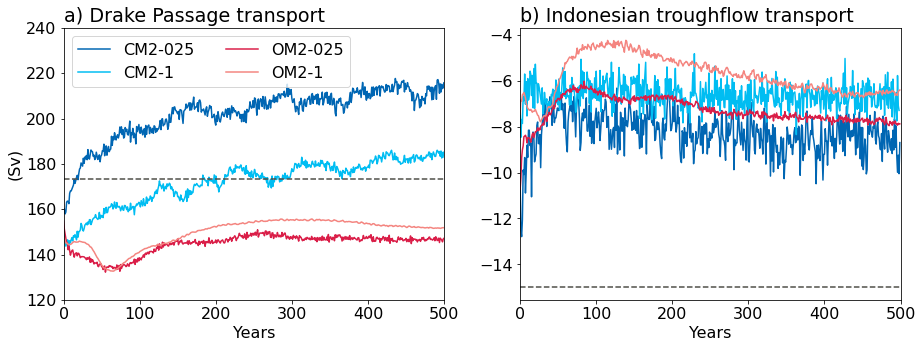

In [22]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('a) Drake Passage transport', loc='left')
plt.plot(DP_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(DP_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(DP_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(DP_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.ylim(120, 240)
plt.axhline(DP, color=CLEX_Gray, linestyle='--')
plt.legend(ncol=2)
plt.ylabel('(Sv)')
plt.xlabel('Years')

plt.subplot(122)
plt.plot(ITF_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(ITF_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(ITF_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(ITF_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.axhline(Total, color=CLEX_Gray, linestyle='--')
plt.title('')
plt.title('b) Indonesian troughflow transport', loc='left')
plt.xlabel('Years')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_DP_ITF_timeseries.png'
    plt.savefig(fig_path + fig_name, dpi=300);

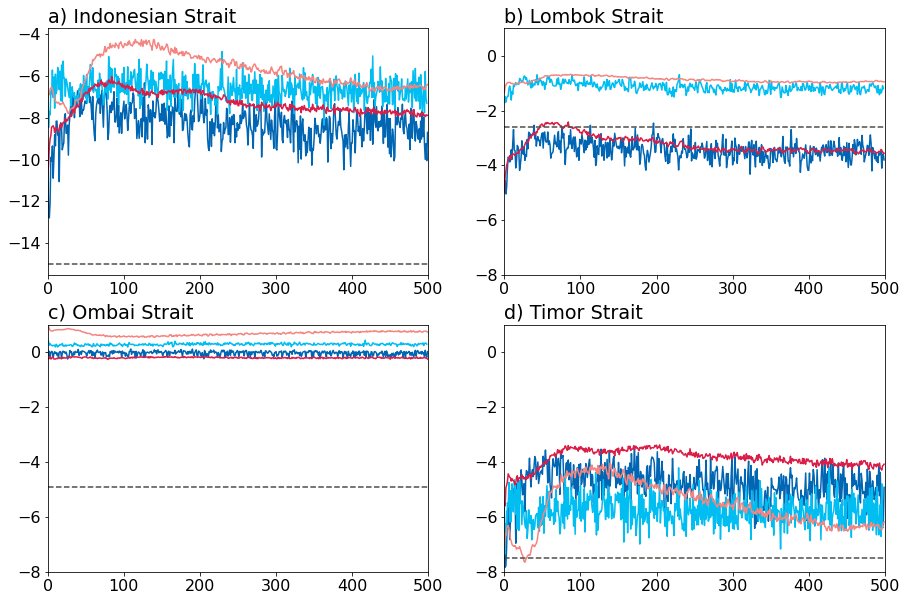

In [26]:
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(ITF_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(ITF_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(ITF_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(ITF_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.axhline(Total, color=CLEX_Gray, linestyle='--')
plt.title('')
plt.title('a) Indonesian Strait', loc='left')

plt.subplot(222)
plt.plot(Lombok_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(Lombok_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(Lombok_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(Lombok_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.ylim(-8, 1)
plt.axhline(Lombok, color=CLEX_Gray, linestyle='--')
plt.title('')
plt.title('b) Lombok Strait', loc='left')

plt.subplot(223)
plt.plot(Ombai_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(Ombai_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(Ombai_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(Ombai_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.ylim(-8, 1)
plt.axhline(Ombai, color=CLEX_Gray, linestyle='--')
plt.title('')
plt.title('c) Ombai Strait', loc='left')

plt.subplot(224)
plt.plot(Timor_CM2_025, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(Timor_CM2_1, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(Timor_OM2_025, color=CLEX_Red, label='OM2-025')
plt.plot(Timor_OM2_1, color=CLEX_Pink, label='OM2-1')
plt.xlim(0, 500)
plt.ylim(-8, 1)
plt.axhline(Timor, color=CLEX_Gray, linestyle='--')
plt.title('')
plt.title('d) Timor Strait', loc='left')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_ITF_timeseries.png'
    plt.savefig(fig_path + fig_name, dpi=300);

In [24]:
fig_path

'/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [27]:
straits = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':     [-244.6+360, -243.9+360, -8.6, -8.6],
              'Ombai' :     [-235.0+360, -235.0+360, -9.2, -8.1],
              'Timor' :     [-235.9+360, -235.9+360, -11.9, -9.9],
              'Bering' :    [-172, -167, 65.8, 65.8],
              'Denmark' :   [-42, -22, 65.8, 65.8],
            }

In [30]:
rho = 1036 # kg/m^3, mean density of seawater

def calc_transport(expt, session, strait, start_time='0001-01-01', end_time='0001-12-31'):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax>=65:
        raise ValueError('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}:{} transport'.format(expt, strait))
    
    if xmin == xmax:                
        tx_trans = cc.querying.getvar(expt, 'tx_trans', session, start_time=start_time, end_time=end_time)
        tx_trans = tx_trans.sel(time=slice(start_time, end_time))
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('st_ocean').sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.

    elif ymin == ymax:
        ty_trans = cc.querying.getvar(expt, 'ty_trans', session, start_time=start_time, end_time=end_time)
        ty_trans = ty_trans.sel(time=slice(start_time, end_time))
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('st_ocean').sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

In [ ]:
transport = calc_transport(expt_OM2_025, session_OM2, 'Ombai', start_time='1900-01-01', end_time='2399-12-31')


In [35]:
transport = transport.resample(time='Y').mean()

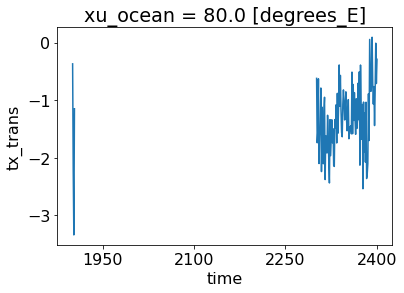

In [37]:
transport.plot()

In [38]:
transport_IAF = calc_transport('01deg_jra55v140_iaf_cycle4', session_OM2, 'Ombai', start_time='1960-01-01', end_time='2018-12-31')

Calculating 01deg_jra55v140_iaf_cycle4:Ombai transport
